In [1]:
# ✅ FastCUT for Hair Removal - Paired Setting
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.models import resnet18
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ----------------------- Dataset ----------------------- #
class HairRemovalDataset(Dataset):
    def __init__(self, image_dir, clean_dir, transform=None):
        self.image_dir = image_dir
        self.clean_dir = clean_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        hair_img = Image.open(os.path.join(self.image_dir, self.image_list[idx])).convert('RGB').resize((256, 256))
        clean_img = Image.open(os.path.join(self.clean_dir, self.image_list[idx])).convert('RGB').resize((256, 256))
        if self.transform:
            hair_img = self.transform(hair_img)
            clean_img = self.transform(clean_img)
        return hair_img, clean_img

# ----------------------- Generator (ResNet-based) ----------------------- #
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]
        for i in range(2):
            model += [
                nn.Conv2d(ngf * 2 ** i, ngf * 2 ** (i + 1), kernel_size=3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(ngf * 2 ** (i + 1)),
                nn.ReLU(True),
            ]
        for _ in range(6):
            model += [
                ResnetBlock(ngf * 4)
            ]
        for i in range(2):
            model += [
                nn.ConvTranspose2d(ngf * 2 ** (2 - i), ngf * 2 ** (1 - i), kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(ngf * 2 ** (1 - i)),
                nn.ReLU(True),
            ]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

# ----------------------- Discriminator ----------------------- #
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

# ----------------------- PatchNCE Loss ----------------------- #
class PatchNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, feat_q, feat_k):
        B, C, H, W = feat_q.shape
        feat_q = feat_q.view(B, C, -1).permute(0, 2, 1)
        feat_k = feat_k.view(B, C, -1)
        logits = torch.bmm(feat_q, feat_k) / self.temperature
        labels = torch.arange(logits.size(1)).long().to(feat_q.device)
        loss = sum(self.cross_entropy_loss(logits[i], labels) for i in range(B)) / B
        return loss

# ----------------------- Training & Evaluation ----------------------- #
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = HairRemovalDataset(
    image_dir="/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    clean_dir="/root/autodl-fs/skin_hair_dataset/alignment/oryginal",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = ResNetGenerator().to(device)
disc = PatchDiscriminator().to(device)
patchnce = PatchNCELoss().to(device)

opt_G = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

for epoch in range(40):
    gen.train(); disc.train()
    g_loss_sum, d_loss_sum = 0, 0
    for hair, clean in tqdm(train_loader):
        hair, clean = hair.to(device), clean.to(device)
        fake_clean = gen(hair)

        # Discriminator
        real_out = disc(hair, clean)
        fake_out = disc(hair, fake_clean.detach())
        d_loss = (bce_loss(real_out, torch.ones_like(real_out)) +
                  bce_loss(fake_out, torch.zeros_like(fake_out))) / 2
        opt_D.zero_grad(); d_loss.backward(); opt_D.step()

        # Generator
        fake_out = disc(hair, fake_clean)
        g_gan = bce_loss(fake_out, torch.ones_like(fake_out))
        g_l1 = l1_loss(fake_clean, clean)
        g_total = g_gan + 10 * g_l1

        opt_G.zero_grad(); g_total.backward(); opt_G.step()

        g_loss_sum += g_total.item()
        d_loss_sum += d_loss.item()

    print(f"Epoch {epoch+1}: G Loss = {g_loss_sum/len(train_loader):.4f}, D Loss = {d_loss_sum/len(train_loader):.4f}")
    torch.save(gen.state_dict(), f"fastcut_gen_epoch{epoch+1}.pth")

# ----------------------- Inference & Quality ----------------------- #
def remove_hair(image_path, model, device):
    image = Image.open(image_path).convert('RGB').resize((256, 256))
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor).squeeze(0).cpu()
    output = (output * 0.5 + 0.5).clamp(0, 1)
    return image, transforms.ToPILImage()(output)

def evaluate_image_quality(gt, pred):
    gt_arr = np.array(gt.resize((256, 256))).astype(np.float32) / 255.0
    pred_arr = np.array(pred.resize((256, 256))).astype(np.float32) / 255.0
    mse = mean_squared_error(gt_arr, pred_arr)
    psnr = peak_signal_noise_ratio(gt_arr, pred_arr, data_range=1.0)
    ssim = structural_similarity(gt_arr, pred_arr, channel_axis=2, data_range=1.0)
    uqi_val = uqi((gt_arr*255).astype(np.uint8), (pred_arr*255).astype(np.uint8))
    return mse, psnr, ssim, uqi_val

gen.eval()
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
gt_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"
image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

mse_list, psnr_list, ssim_list, uqi_list = [], [], [], []

for name in image_names:
    input_path = os.path.join(image_dir, name)
    gt_path = os.path.join(gt_dir, name)
    if not os.path.exists(gt_path):
        continue
    gt_img = Image.open(gt_path).convert("RGB")
    _, pred_img = remove_hair(input_path, gen, device)
    mse, psnr, ssim, uqi_val = evaluate_image_quality(gt_img, pred_img)
    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    uqi_list.append(uqi_val)

print("\n=== FastCUT Hair Removal Image Quality ===")
print(f"MSE   : {np.mean(mse_list):.6f}")
print(f"PSNR  : {np.mean(psnr_list):.2f} dB")
print(f"SSIM  : {np.mean(ssim_list):.4f}")
print(f"UQI   : {np.mean(uqi_list):.4f}")

100%|██████████| 19/19 [00:06<00:00,  2.90it/s]


Epoch 1: G Loss = 3.0088, D Loss = 0.6805


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 2: G Loss = 2.8084, D Loss = 0.6186


100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Epoch 3: G Loss = 3.0024, D Loss = 0.5374


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 4: G Loss = 3.2138, D Loss = 0.3952


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 5: G Loss = 3.5595, D Loss = 0.3347


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 6: G Loss = 4.0081, D Loss = 0.2050


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 7: G Loss = 4.2830, D Loss = 0.2041


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 8: G Loss = 4.3583, D Loss = 0.1667


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch 9: G Loss = 4.8652, D Loss = 0.0952


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch 10: G Loss = 5.1822, D Loss = 0.0628


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 11: G Loss = 5.3968, D Loss = 0.0611


100%|██████████| 19/19 [00:06<00:00,  3.01it/s]


Epoch 12: G Loss = 5.5982, D Loss = 0.0461


100%|██████████| 19/19 [00:06<00:00,  3.05it/s]


Epoch 13: G Loss = 5.7956, D Loss = 0.0341


100%|██████████| 19/19 [00:06<00:00,  3.07it/s]


Epoch 14: G Loss = 5.8070, D Loss = 0.0293


100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


Epoch 15: G Loss = 6.0163, D Loss = 0.0296


100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Epoch 16: G Loss = 6.2821, D Loss = 0.1164


100%|██████████| 19/19 [00:06<00:00,  3.05it/s]


Epoch 17: G Loss = 5.3183, D Loss = 0.1080


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 18: G Loss = 5.9205, D Loss = 0.0330


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 19: G Loss = 6.2225, D Loss = 0.0254


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 20: G Loss = 6.1958, D Loss = 0.0232


100%|██████████| 19/19 [00:06<00:00,  3.01it/s]


Epoch 21: G Loss = 6.6881, D Loss = 0.0191


100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


Epoch 22: G Loss = 6.8723, D Loss = 0.0209


100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Epoch 23: G Loss = 6.8424, D Loss = 0.0165


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 24: G Loss = 6.8710, D Loss = 0.0155


100%|██████████| 19/19 [00:06<00:00,  3.05it/s]


Epoch 25: G Loss = 6.9432, D Loss = 0.0129


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 26: G Loss = 7.0033, D Loss = 0.0126


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 27: G Loss = 7.1033, D Loss = 0.0112


100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


Epoch 28: G Loss = 7.1681, D Loss = 0.0115


100%|██████████| 19/19 [00:06<00:00,  3.09it/s]


Epoch 29: G Loss = 5.5693, D Loss = 0.4517


100%|██████████| 19/19 [00:06<00:00,  3.05it/s]


Epoch 30: G Loss = 5.2351, D Loss = 0.0909


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch 31: G Loss = 5.9711, D Loss = 0.0344


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch 32: G Loss = 6.2465, D Loss = 0.0209


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 33: G Loss = 6.5919, D Loss = 0.0218


100%|██████████| 19/19 [00:06<00:00,  3.03it/s]


Epoch 34: G Loss = 6.6613, D Loss = 0.0208


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch 35: G Loss = 7.1842, D Loss = 0.0124


100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


Epoch 36: G Loss = 6.9605, D Loss = 0.0120


100%|██████████| 19/19 [00:06<00:00,  3.05it/s]


Epoch 37: G Loss = 7.2541, D Loss = 0.0135


100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Epoch 38: G Loss = 7.2120, D Loss = 0.0125


100%|██████████| 19/19 [00:06<00:00,  3.00it/s]


Epoch 39: G Loss = 7.3814, D Loss = 0.0098


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch 40: G Loss = 7.3440, D Loss = 0.0105

=== FastCUT Hair Removal Image Quality ===
MSE   : 0.012766
PSNR  : 19.27 dB
SSIM  : 0.3448
UQI   : 0.9545



=== FastCUT Hair Removal Image Quality ===
MSE   : 0.012766
PSNR  : 19.27 dB
SSIM  : 0.3448
UQI   : 0.9545


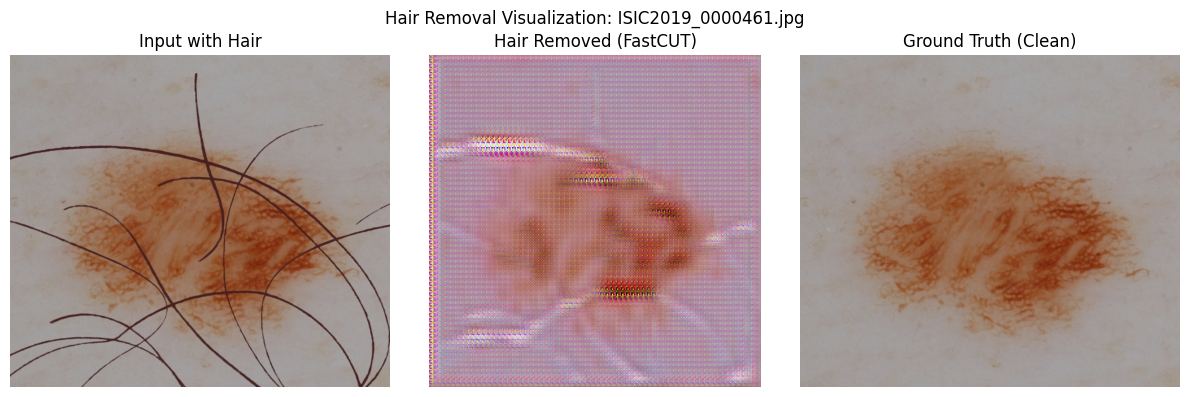

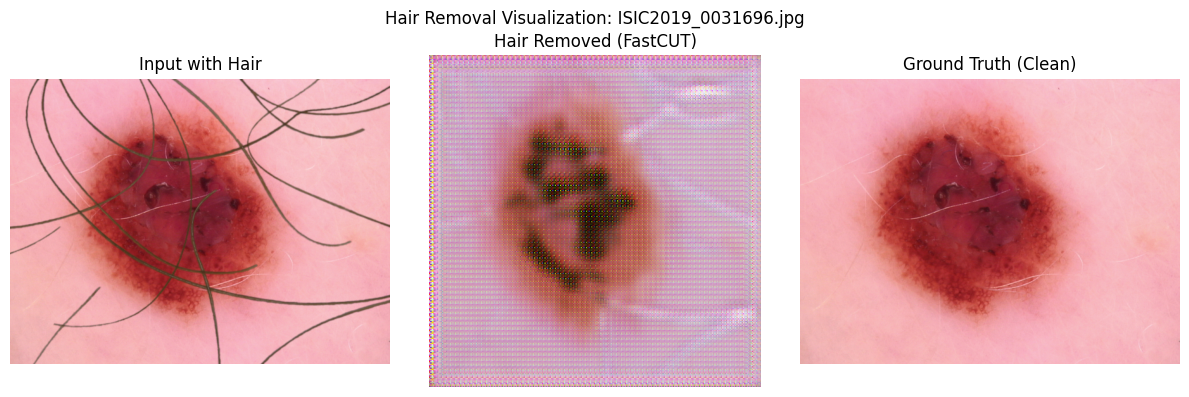

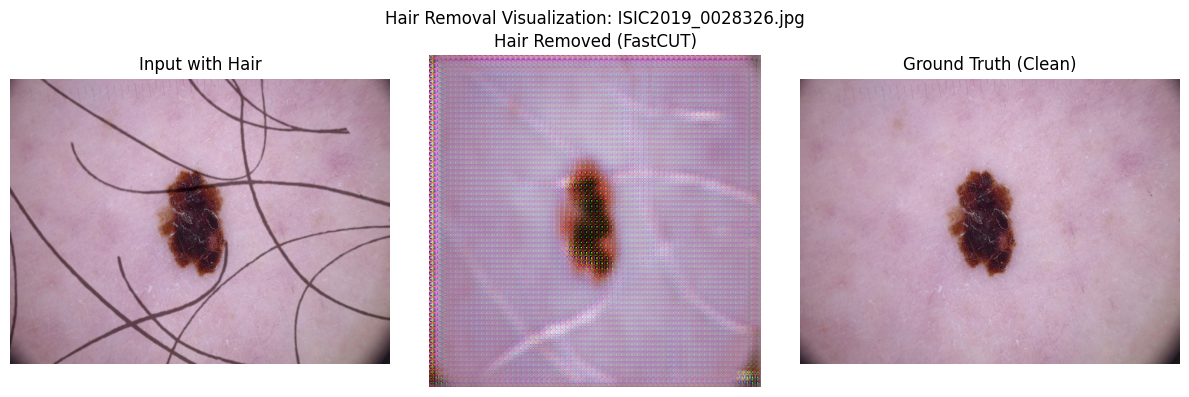

In [3]:
# ✅ FastCUT for Hair Removal - Paired Setting


print("\n=== FastCUT Hair Removal Image Quality ===")
print(f"MSE   : {np.mean(mse_list):.6f}")
print(f"PSNR  : {np.mean(psnr_list):.2f} dB")
print(f"SSIM  : {np.mean(ssim_list):.4f}")
print(f"UQI   : {np.mean(uqi_list):.4f}")

# ----------------------- Visualization ----------------------- #
visual_names = ["ISIC2019_0000461.jpg", "ISIC2019_0031696.jpg", "ISIC2019_0028326.jpg"]
for name in visual_names:
    input_path = os.path.join(image_dir, name)
    gt_path = os.path.join(gt_dir, name)
    if not os.path.exists(gt_path):
        continue
    input_img = Image.open(input_path).convert("RGB")
    gt_img = Image.open(gt_path).convert("RGB")
    _, pred_img = remove_hair(input_path, gen, device)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title("Input with Hair")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_img)
    plt.title("Hair Removed (FastCUT)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(gt_img)
    plt.title("Ground Truth (Clean)")
    plt.axis("off")

    plt.suptitle(f"Hair Removal Visualization: {name}")
    plt.tight_layout()
    plt.show()